In [31]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders2.csv', 'orders'),
    ('sellers.csv', 'sales'),
    ('products.csv', 'products'),
    ('payments.csv', 'payments'),
    ("geolocational.csv",'geolocational'),
    ("order_items.csv","order_items")
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='SQL@123',
    database='Ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Rahul/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host = "localhost",
    username= "root",
    password="SQL@123",
    database= "Ecommerce"
)

cur = db.cursor()


 # List all unique cities where customers are located.


In [2]:
query = """SELECT distinct customer_city FROM Ecommerce.customers;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=[''])
df.head()

,
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


Count the number of orders placed in 2017.

In [3]:
query = """SELECT count(order_id) FROM Ecommerce.orders2
WHERE YEAR(order_purchase_date)=2017;"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

5229

# Find the total sales per category.

In [4]:
query = """select products.product_category category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category"""
cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of oders that were paid in installments

In [5]:
query = """select (sum(case when payment_installments>= 1 then 1
else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
"the percentage of oders that were paid in installments", data

('the percentage of oders that were paid in installments',
 [(Decimal('99.9981'),)])

# count the number of customers from each state

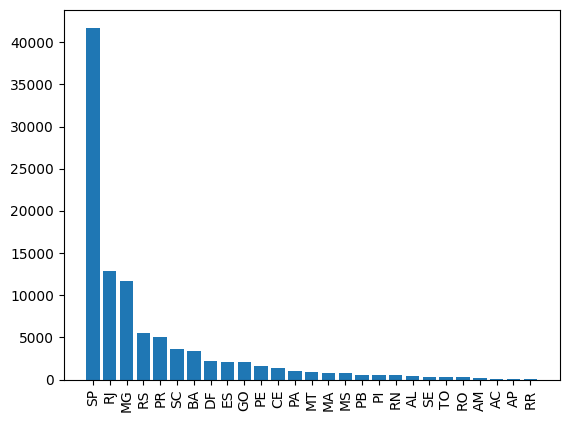

<Figure size 800x300 with 0 Axes>

In [6]:
query="""select count(*), customer_state
from ecommerce.customers
group by customer_state;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["count","state"])
df = df.sort_values(by = "count",ascending = False)
plt.bar(df['state'],df["count"])
plt.xticks(rotation =90)
plt.figure(figsize= (8,3))
plt.show()

# Calculate numbers of orders per month in 2018

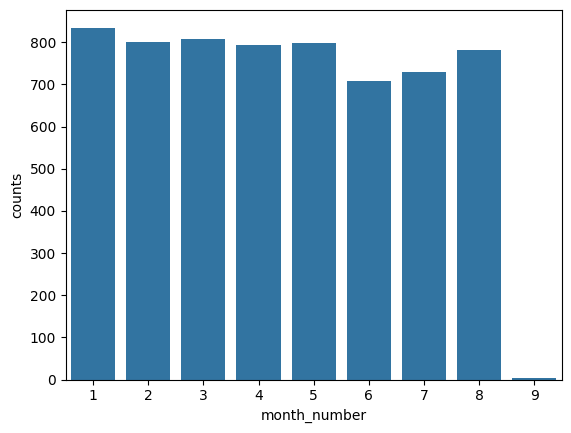

In [8]:
query = """select count(order_id), month(order_purchase_date) as months
from ecommerce.orders2
where year(order_purchase_date)=2018
group by months;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns= ['counts',"month_number"])
o = ["Jan","Feb","Mar","Apr","may","Jun","Jul","Ogs","Sep"]
sns.barplot(x= df["month_number"],y=df["counts"],data=df)
plt.show()


# find the Average number of products per order, grouped by customer city


In [11]:
query = """with count_per_order as
(select orders2.order_id,orders2.customer_id, count(order_items.order_id) as oc
from orders2 join order_items
on orders2.order_id = order_items.order_id
group by orders2.order_id,orders2.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2)
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Customer_city',"average_orders"])
df.head(10)

,Customer_city,average_orders
0,sao jose dos campos,1.24
1,indaial,1.33
2,treze tilias,1.00
3,sao paulo,1.15
4,rio de janeiro,1.15
5,mario campos,1.00
6,guariba,1.00
7,cuiaba,1.10
8,franca,1.11
9,tocos,1.00


# Calculate the percentage of total revenue contributed by each product category


In [7]:
query = """select products.product_category category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,perfumery,3.17
1,Furniture Decoration,8.93
2,telephony,3.04
3,Fashion Bags and Accessories,1.36
4,bed table bath,10.70
...,...,...
69,cds music dvds,0.01
70,La Cuisine,0.02
71,Fashion Children's Clothing,0.00
72,PC Gamer,0.01


# identify the correlation between product price and number of times a product has been purchesed.

In [16]:
query = """select products.product_category, count(order_items.product_id), 
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['category','order_count','price'])

arr1 = df['order_count']
arr2 = df['price']
a = np.corrcoef([arr1,arr2])
print("The correlation between price and number of times product has been purchesed ", a[0][-1])

The correlation between price and number of times product has been purchesed  -0.10631514167157562


# Calculate total revenue generated by each seller and rank them based on the revenue.

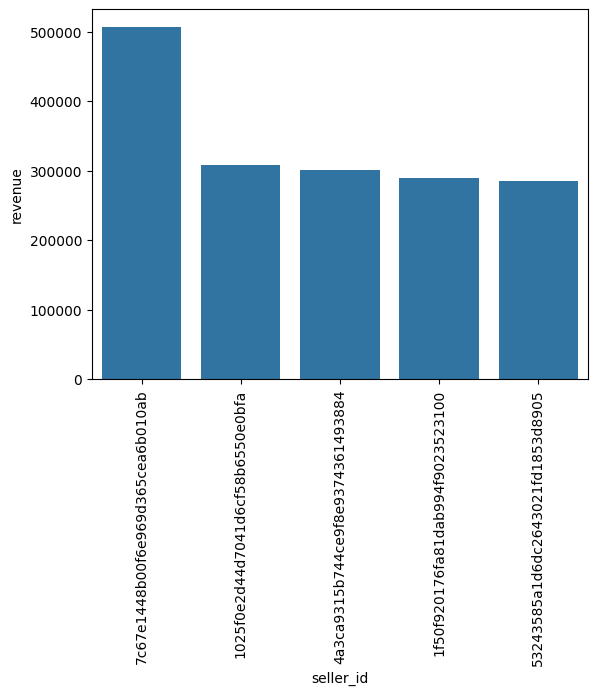

In [26]:
query = """select * , dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id, sum(payments.payment_value) as revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by seller_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['seller_id',"revenue","rank"])
df=df.head()
sns.barplot(x = 'seller_id',y= 'revenue', data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each  customer over their order history.

In [28]:
query = """select customer_id,order_purchase_date, payment,
avg(payment) over(partition by customer_id order by order_purchase_date 
rows between 2 preceding and current row) as moving_avg
from
(select orders2.customer_id, orders2.order_purchase_date, payments.payment_value as payment
from payments join orders2
on payments.order_id = orders2.order_id) as a;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,000161a058600d5901f007fab4c27140,2017-07-16,67.41,67.410004
1,000379cdec625522490c315e70c7a9fb,2018-04-02,107.01,107.010002
2,0005aefbb696d34b3424dccd0a0e9fd0,2018-06-20,147.33,147.330002
3,00146ad30454993879adaa91c518f68c,2018-01-08,221.79,221.789993
4,0018c09f333634ca9c80d9ff46e43e9c,2018-07-01,56.87,56.869999
...,...,...,...,...
12028,ffdd80d8f3655192a9d2a38d5b18732c,2017-11-24,106.16,106.160004
12029,ffe0aaaac429db7837e943b83ee6c385,2017-06-29,227.27,227.270004
12030,ffe6d825d8a60d5cca942bcc57e9d8e6,2017-05-05,84.45,84.449997
12031,ffe82abbde8061e75c4c0b72f3b2accf,2018-06-14,139.41,139.410004


# Calculate the Cumulative sales per month for each year

In [29]:
query="""select years , months,payment, sum(payment)
over(order by years,months)  as cumulative_sales from

(select year(orders2.order_purchase_date) as years, month(orders2.order_purchase_date)
as months, round(sum(payments.payment_value),2) as payment from orders2 join payments
on orders2.order_id = payments.order_id
group by years, months
order by years , months) as a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,6420.17,6672.41
2,2017,1,14706.13,21378.54
3,2017,2,34115.99,55494.53
4,2017,3,47645.25,103139.78
5,2017,4,41282.50,144422.28
6,2017,5,73901.13,218323.41
7,2017,6,56673.42,274996.83
8,2017,7,69696.95,344693.78
9,2017,8,81566.07,426259.85


# Calculate the year-over-year growth rate of total sales.


In [3]:
query = '''with a as (select year(orders2.order_purchase_date) as years, round(sum(payments.payment_value),2) as payment
from orders2 join payments
on orders2.order_id = payments.order_id
group by years
order by years)

select years, ((payment-lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100
as previuos_year from a
;'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['years',"year-over_year_growth"])
df

,years,year-over_year_growth
0,2016,NaN
1,2017,12302.066120
2,2018,25.122387


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [4]:
query = '''with a as 
(select customers.customer_id,min(orders2.order_purchase_date) as first_order
from customers join orders2 on 
customers.customer_id = orders2.customer_id
group by customers.customer_id)

(select a.customer_id,count(distinct orders2.order_purchase_date)
from a join orders2
on orders2.customer_id = a.customer_id
and orders2.order_purchase_date> first_order
and orders2.order_purchase_date < date_add(first_order,interval 6 month)
group by a.customer_id)
;'''

cur.execute(query)
data = cur.fetchall()
data

[]